## Read Data

In [9]:
import pandas as pd
from google.colab import files
uploaded = files.upload("chunksize=1*1024*1024")


Saving news_category_dataset.json to chunksize=1*1024*1024/news_category_dataset.json


In [10]:
#this assumes one json item per line in json file
df = pd.read_json('news_category_dataset.json', lines=True)

In [11]:
df.dtypes

,0
short_description,object
headline,object
date,datetime64[ns]
link,object
authors,object
category,object


In [12]:
#number of rows (datapoints)
len(df)

124989

In [13]:
df.sample(100)

,short_description,headline,date,link,authors,category
459,"“Are you looking to spend $100,000 you don’t h...",Trevor Noah Skewers Betsy DeVos With Fake For-...,2018-05-17,https://www.huffingtonpost.com/entry/trevor-no...,Lee Moran,COMEDY
44881,Pitt is reportedly under investigation regardi...,Angelina Jolie And Her Kids Reportedly Intervi...,2016-10-19,https://www.huffingtonpost.com/entry/angelina-...,Julia Brucculieri,ENTERTAINMENT
83887,"Yes, this is a thing.","If You Think The Apple Watch Is Ridiculous, Yo...",2015-08-04,https://www.huffingtonpost.com/entry/apple-wat...,Alexandra Ma,TECH
54058,Asked and answered.,"How To Get The Perfect Shave, According To The...",2016-07-07,https://www.huffingtonpost.com/entry/how-to-ge...,James Cave,STYLE
11754,It's unBEARable.,This 6-Foot-5-Inch Teddy Bear Is All Legs And ...,2017-11-15,https://www.huffingtonpost.com/entry/teddy-bea...,Carly Ledbetter,WEIRD NEWS
...,...,...,...,...,...,...
121000,Self-esteem can be a lifelong pursuit. We may ...,Why It's Important to Learn the Difference Bet...,2014-06-05,https://www.huffingtonpost.com/entry/why-its-i...,"Cathy Chester, ContributorAward-winning blogge...",FIFTY
52713,"It pains us to say it, but these cakes might b...",These Breathtakingly Beautiful Cakes Are Strai...,2016-07-22,https://www.huffingtonpost.com/entry/beautiful...,Abigail Williams,TASTE
68264,"""You have to appreciate who you are in order t...",Meet The Visionary Chicago School Leader Who J...,2016-01-27,https://www.huffingtonpost.com/entry/juan-salg...,"Heather Martino, The Seventy Four",IMPACT
81240,There's a second video of the incident that au...,Sheriff Says Man Killed With Hands In Air Poss...,2015-09-02,https://www.huffingtonpost.com/entry/sheriff-s...,,CRIME


## Date range
Articles are between July 2014 and July 2018

<Axes: >

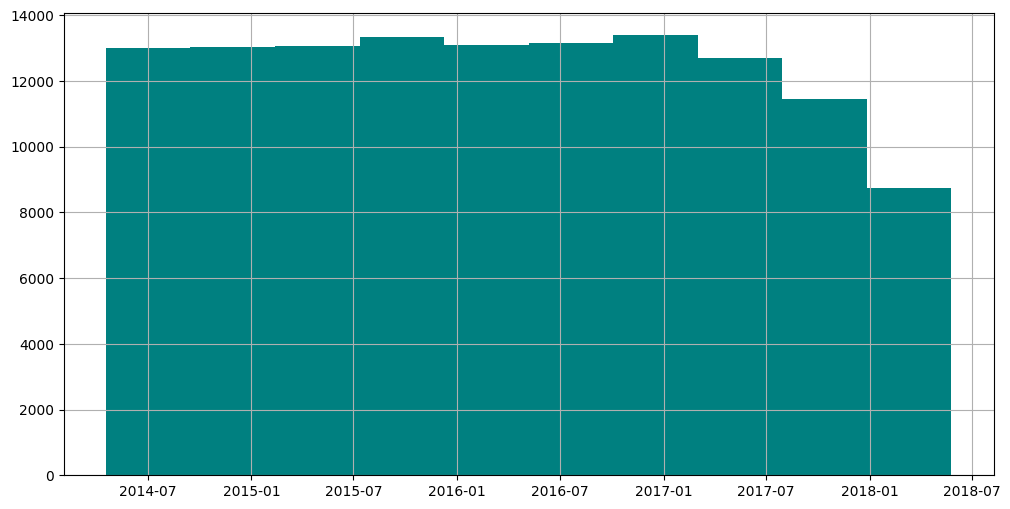

In [14]:
df.date.hist(figsize=(12,6),color='teal',)


## Category Distribution

### Number of categories

In [15]:
len(set(df['category'].values))

31

### Category by count

Most of the articles are related to politics. Education related articles have the lowest volume.

<Axes: xlabel='category'>

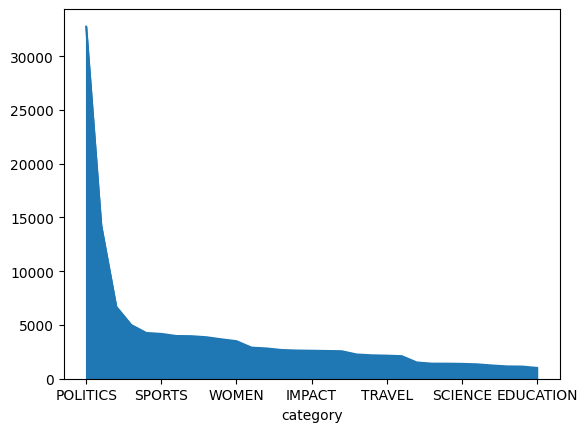

In [26]:
df['category'].value_counts().plot(kind='area')

## Texts for Classification

These are some of the fields we can use for the classification task. We create 3 different versions.

In [27]:
import re

def tokenize_url(url:str):
    url=url.replace("https://www.huffingtonpost.com/entry/","")
    url=re.sub("(\W|_)+"," ",url)
    return url

df['tokenized_url']=df['link'].apply(lambda x:tokenize_url(x))

#just the description
df['text_desc'] = df['short_description']

#description + headline
df['text_desc_headline'] = df['short_description'] + ' '+ df['headline']

#description + headline + tokenized url
df['text_desc_headline_url'] = df['short_description'] + ' '+ df['headline']+" " + df['tokenized_url']


In [28]:
def _reciprocal_rank(true_labels: list, machine_preds: list):
    """Compute the reciprocal rank at cutoff k"""

    # add index to list only if machine predicted label exists in true labels
    tp_pos_list = [(idx + 1) for idx, r in enumerate(machine_preds) if r in true_labels]

    rr = 0
    if len(tp_pos_list) > 0:
        # for RR we need position of first correct item
        first_pos_list = tp_pos_list[0]

        # rr = 1/rank
        rr = 1 / float(first_pos_list)

    return rr

def compute_mrr_at_k(items:list):
    """Compute the MRR (average RR) at cutoff k"""
    rr_total = 0

    for item in items:
        rr_at_k = _reciprocal_rank(item[0],item[1])
        rr_total = rr_total + rr_at_k
        mrr = rr_total / 1/float(len(items))

    return mrr

def collect_preds(Y_test,Y_preds):
    """Collect all predictions and ground truth"""

    pred_gold_list=[[[Y_test[idx]],pred] for idx,pred in enumerate(Y_preds)]
    return pred_gold_list

def compute_accuracy(eval_items:list):
    correct=0
    total=0

    for item in eval_items:
        true_pred=item[0]
        machine_pred=set(item[1])

        for cat in true_pred:
            if cat in machine_pred:
                correct+=1
                break


    accuracy=correct/float(len(eval_items))
    return accuracy


In [29]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

import numpy as np
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

def extract_features(df,field,training_data,testing_data,type="binary"):
    """Extract features using different methods"""

    logging.info("Extracting features and creating vocabulary...")

    if "binary" in type:

        # BINARY FEATURE REPRESENTATION
        cv= CountVectorizer(binary=True, max_df=0.95)
        cv.fit_transform(training_data[field].values)

        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)

        return train_feature_set,test_feature_set,cv

    elif "counts" in type:

        # COUNT BASED FEATURE REPRESENTATION
        cv= CountVectorizer(binary=False, max_df=0.95)
        cv.fit_transform(training_data[field].values)

        train_feature_set=cv.transform(training_data[field].values)
        test_feature_set=cv.transform(testing_data[field].values)

        return train_feature_set,test_feature_set,cv

    else:

        # TF-IDF BASED FEATURE REPRESENTATION
        tfidf_vectorizer=TfidfVectorizer(use_idf=True, max_df=0.95)
        tfidf_vectorizer.fit_transform(training_data[field].values)

        train_feature_set=tfidf_vectorizer.transform(training_data[field].values)
        test_feature_set=tfidf_vectorizer.transform(testing_data[field].values)

        return train_feature_set,test_feature_set,tfidf_vectorizer

def get_top_k_predictions(model,X_test,k):

    # get probabilities instead of predicted labels, since we want to collect top 3
    probs = model.predict_proba(X_test)

    # GET TOP K PREDICTIONS BY PROB - note these are just index
    best_n = np.argsort(probs, axis=1)[:,-k:]

    # GET CATEGORY OF PREDICTIONS
    preds=[[model.classes_[predicted_cat] for predicted_cat in prediction] for prediction in best_n]

    preds=[ item[::-1] for item in preds]

    return preds


def train_model(df,field="text_desc",feature_rep="binary",top_k=3):

    logging.info("Starting model training...")

    # GET A TRAIN TEST SPLIT (set seed for consistent results)
    training_data, testing_data = train_test_split(df,random_state = 2000,)

    # GET LABELS
    Y_train=training_data['category'].values
    Y_test=testing_data['category'].values

    # GET FEATURES
    X_train,X_test,feature_transformer=extract_features(df,field,training_data,testing_data,type=feature_rep)

    # INIT LOGISTIC REGRESSION CLASSIFIER
    logging.info("Training a Logistic Regression Model...")
    scikit_log_reg = LogisticRegression(verbose=1, solver='liblinear',random_state=0, C=5, penalty='l2',max_iter=1000)
    model=scikit_log_reg.fit(X_train,Y_train)

    # GET TOP K PREDICTIONS
    preds=get_top_k_predictions(model,X_test,top_k)

    # GET PREDICTED VALUES AND GROUND TRUTH INTO A LIST OF LISTS - for ease of evaluation
    eval_items=collect_preds(Y_test,preds)

    # GET EVALUATION NUMBERS ON TEST SET -- HOW DID WE DO?
    logging.info("Starting evaluation...")
    accuracy=compute_accuracy(eval_items)
    mrr_at_k=compute_mrr_at_k(eval_items)

    logging.info("Done training and evaluation.")

    return model,feature_transformer,accuracy,mrr_at_k


## Train a Single Model

### Model  - 1  (binary features with description only)

In [30]:
field='text_desc'
feature_rep='binary'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

[LibLinear]
Accuracy=0.5980862775217614; MRR=0.480516086362876


### Model - 2 (tfidf features with description only)

In [31]:
field='text_desc'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

[LibLinear]
Accuracy=0.6306643625192012; MRR=0.5108326932923889


### Model - 3 (tfidf features with description, headline, url)

In [32]:
field='text_desc_headline_url'
feature_rep='tfidf'
top_k=3

model,transformer,accuracy,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
print("\nAccuracy={0}; MRR={1}".format(accuracy,mrr_at_k))

[LibLinear]
Accuracy=0.8672875064004096; MRR=0.7511734084314612


## Check Predictions on Unseen Articles from CNN (not HuffPost our training data)

In [38]:
# https://www.cnn.com/2019/07/19/politics/george-nader-child-porn-sex-charges/index.html
test_features=transformer.transform(["George Aref Nader, who was a key witness in special counsel Robert Mueller's Russia investigation, faces new charges of transporting a minor with intent to engage in criminal sexual activity and child pornography"])
get_top_k_predictions(model,test_features,2)

[['POLITICS', 'CRIME']]

In [37]:
# https://www.cnn.com/2019/07/18/entertainment/khloe-kardashian-true-thompson-video-trnd/index.html
test_features=transformer.transform(["True Thompson makes an adorable cameo in Khloe Kardashian's new makeup tutorial video"])
model.predict(test_features)
get_top_k_predictions(model,test_features,2)

[['ENTERTAINMENT', 'STYLE']]

In [39]:
# https://www.cnn.com/2019/07/12/entertainment/heidi-klum-tom-kaulitz/
test_features=transformer.transform(["Heidi Klum is apparently the latest celeb to get married and not tell us"])
get_top_k_predictions(model,test_features,2)

[['ENTERTAINMENT', 'STYLE']]

In [40]:
# https://www.cnn.com/2019/07/19/investing/dow-stock-market-today/index.html
test_features=transformer.transform(["Stocks end lower as geopolitical fears rise. The Dow and US markets closed lower on Friday, as geopolitical worries overshadowed the hopes of interest rate cuts by the Federal Reserve."])
get_top_k_predictions(model,test_features,2)

[['BUSINESS', 'POLITICS']]

In [36]:
# https://www.cnn.com/2019/07/19/health/astronaut-exercise-iv-faint-scn/index.html
test_features=transformer.transform(["Exercise in space keeps astronauts from fainting when they return to Earth, study says. "])
get_top_k_predictions(model,test_features,2)

[['SCIENCE', 'HEALTHY LIVING']]

## Train Different Types of Models

In [34]:
feature_reps=['binary','counts','tfidf']
fields=['text_desc','text_desc_headline','text_desc_headline_url']
top_ks=[3]

results=[]
for field in fields:
    for feature_rep in feature_reps:
        for top_k in top_ks:
            model,transformer,acc,mrr_at_k=train_model(df,field=field,feature_rep=feature_rep,top_k=top_k)
            results.append([field,feature_rep,top_k,acc,mrr_at_k])
            print("\nAccuracy={0}; MRR={1}".format(acc,mrr_at_k))

[LibLinear]
Accuracy=0.5980862775217614; MRR=0.480516086362876
[LibLinear]
Accuracy=0.595526113671275; MRR=0.47842528588497907
[LibLinear]
Accuracy=0.6306643625192012; MRR=0.5108326932923889
[LibLinear]
Accuracy=0.7946108550947261; MRR=0.6791688001365371
[LibLinear]
Accuracy=0.7921466973886329; MRR=0.6779153865847366
[LibLinear]
Accuracy=0.8359254992319508; MRR=0.7172245690390758
[LibLinear]
Accuracy=0.8301011264720942; MRR=0.7155924645843906
[LibLinear]
Accuracy=0.8297171018945213; MRR=0.7181259600614363
[LibLinear]
Accuracy=0.8672875064004096; MRR=0.7511734084314612


### Results of Various Models

In [41]:
df_results=pd.DataFrame(results,columns=['text_fields','feature_representation','top_k','accuracy','mrr_at_k'])
df_results.sort_values(by=['text_fields','accuracy'],ascending=False)

,text_fields,feature_representation,top_k,accuracy,mrr_at_k
8,text_desc_headline_url,tfidf,3,0.867288,0.751173
6,text_desc_headline_url,binary,3,0.830101,0.715592
7,text_desc_headline_url,counts,3,0.829717,0.718126
5,text_desc_headline,tfidf,3,0.835925,0.717225
3,text_desc_headline,binary,3,0.794611,0.679169
4,text_desc_headline,counts,3,0.792147,0.677915
2,text_desc,tfidf,3,0.630664,0.510833
0,text_desc,binary,3,0.598086,0.480516
1,text_desc,counts,3,0.595526,0.478425


## Save Model for Future Use


In [43]:
import os
import pickle

model_path = "../models/model.pkl"
transformer_path = "../models/transformer.pkl"

# Create the models directory if it doesn't exist
if not os.path.exists(os.path.dirname(model_path)):
    os.makedirs(os.path.dirname(model_path))

# Save the model and transformer
pickle.dump(model, open(model_path, 'wb'))
pickle.dump(transformer, open(transformer_path, 'wb'))


## Use Loaded Model

In [46]:
loaded_model = pickle.load(open(model_path, 'rb'))
loaded_transformer = pickle.load(open(transformer_path, 'rb'))


test_features=loaded_transformer.transform(["President Trump AND THE impeachment story !!!"])
get_top_k_predictions(loaded_model,test_features,2)


[['POLITICS', 'THE WORLDPOST']]